In [5]:
import pandas as pd
import numpy
import pickle
from glob import glob
from tqdm.auto import tqdm
import math
import torch
%pylab inline
from IPython.display import set_matplotlib_formats
from matplotlib.ticker import FormatStrFormatter
set_matplotlib_formats('png')
import scipy

from run_experiment import generate_sequence_space, config_factory

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 10

In [3]:
config = config_factory(1)
seq_space = generate_sequence_space(config)
lengths = (seq_space != 7).sum(1)

Running {'seed': 7820, 'true_config': 'laplace_only', 'model_hs': 128, 'training_set_size': 100000} config out of 300...


In [5]:
df = pickle.load(open('<PATH TO RESULTS FROM compute_pkl.py>', 'rb'))

In [4]:
# df1 = pickle.load(open('../../mode_recovery_processed_pkls/02_12_wintrs.pkl', 'rb'))
# df2 = pickle.load(open('../../mode_recovery_processed_pkls/02_14_wintrs_moreseeds.pkl', 'rb'))

# df = pd.concat([df1, df2], axis=0, ignore_index=True)

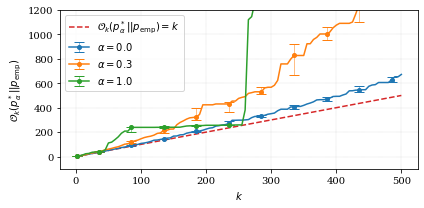

In [6]:
# Fig.1

gt_confs = {
        r'$\alpha = 0.0$': {
            "gt_interpolation": 0.0,
            "gt_interpolation_mode": 'p',
        },
        r'$\alpha = 0.3$': {
            "gt_interpolation": 0.3,
            "gt_interpolation_mode": 'logp',
        },
        r'$\alpha = 1.0$': {
            "gt_interpolation": 1.0,
            "gt_interpolation_mode": 'p',
        },

    }


fig, ax = plt.subplots(1,1, figsize=(6,3))

k_list = df['k_list'][0]
training_set_sizes = df['training_set_size'].sort_values().unique()
ts_to_plot = training_set_sizes[1]

metric_name = 'cost_true_emp'
ylabel = {
    "cost_true_emp": r"$\mathcal{O}_{k}(p^*_{\alpha}|| p_\mathrm{emp})$"
}

for i_offset, (gt_label, gt_config) in enumerate(gt_confs.items()):
    true_emp_cost = numpy.array(df.loc[(df['gt_interpolation'] == gt_config['gt_interpolation']) & (df['gt_interpolation_mode'] == gt_config['gt_interpolation_mode']) & (df['true_hs'] > 0) & (df['training_set_size'] == ts_to_plot) & (df['model_hs'] == 512)][metric_name].to_list())
    median_cost = numpy.quantile(true_emp_cost, axis=0, q=0.5)
    lower_quantile = numpy.quantile(true_emp_cost, axis=0, q=0.25)
    #print(lower_quantile)
    upper_quntile = numpy.quantile(true_emp_cost, axis=0, q=0.75)
    ax.errorbar(k_list, y=median_cost, yerr=[median_cost-lower_quantile, upper_quntile-median_cost], label=gt_label, errorevery=10, elinewidth=0.5, capsize=5., marker='o', markersize=4, markevery=10)

#plot_len_segments(ax)
ax.plot(k_list, k_list, label=r'$\mathcal{O}_{k}(p^*_{\alpha}|| p_\mathrm{emp})=k$', ls='--')
ax.set_ylabel(ylabel[metric_name])
ax.set_xlabel(r'$k$')
ax.set_ylim(-100,1200)
ax.grid(lw=0.2, ls='--')
#ax.set_title(ts_to_plot)
ax.legend()
plt.tight_layout()

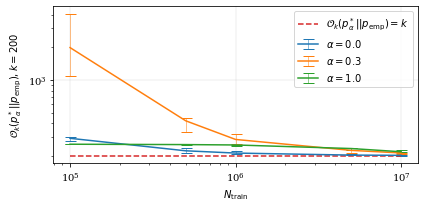

In [7]:
# Fig. 2

gt_confs = {
        r'$\alpha = 0.0$': {
            "gt_interpolation": 0.0,
            "gt_interpolation_mode": 'p',
        },
        r'$\alpha = 0.3$': {
            "gt_interpolation": 0.3,
            "gt_interpolation_mode": 'logp',
        },
        r'$\alpha = 1.0$': {
            "gt_interpolation": 1.0,
            "gt_interpolation_mode": 'p',
        },
    }

cost_ks = [200]
fig, ax = plt.subplots(1,1, figsize=(6,3))


for axi, cost_k in enumerate(cost_ks):
    metric_name = f'cost_true_emp'
    training_set_sizes = df['training_set_size'].sort_values().unique()
    k_list = df['k_list'][0]
    k_mapped = k_list.index(cost_k)


    for i_offset, (gt_label, gt_config) in enumerate(gt_confs.items()):
        cost_fixed_k = []
        for ts in training_set_sizes:
            cost_all_k = numpy.array(df.loc[(df['gt_interpolation'] == gt_config['gt_interpolation']) & (df['gt_interpolation_mode'] == gt_config['gt_interpolation_mode']) & (df['true_hs'] > 0) & (df['training_set_size'] == ts) & (df['model_hs'] == 512)][metric_name].to_list())
            cost_fixed_k.append(cost_all_k[:, k_mapped, None])
        cost_fixed_k = numpy.concatenate(cost_fixed_k, axis=1)
        median_cost = numpy.quantile(cost_fixed_k, axis=0, q=0.5)
        lower_quantile = numpy.quantile(cost_fixed_k, axis=0, q=0.25)
        upper_quntile = numpy.quantile(cost_fixed_k, axis=0, q=0.75)

        xs = training_set_sizes
        ax.errorbar(xs, y=median_cost, yerr=[median_cost-lower_quantile, upper_quntile-median_cost], label=gt_label, elinewidth=0.5, capsize=5.5)

    ax.plot(xs, [cost_k]*xs.size, linestyle='--', label=r'$\mathcal{O}_{k}(p^*_{\alpha}|| p_\mathrm{emp})=k$')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$N_\mathrm{train}$')
    ax.set_ylabel(r'$\mathcal{O}_{k}(p^*_{\alpha}|| p_\mathrm{emp}), k=%d$' % cost_k)
    ax.grid(lw=0.2)
plt.tight_layout()
plt.show()

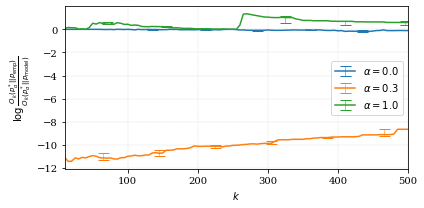

In [8]:
# Fig. 3

gt_confs = {
        r'$\alpha = 0.0$': {
            "gt_interpolation": 0.0,
            "gt_interpolation_mode": 'p',
        },
        r'$\alpha = 0.3$': {
            "gt_interpolation": 0.3,
            "gt_interpolation_mode": 'logp',
        },
        r'$\alpha = 1.0$': {
            "gt_interpolation": 1.0,
            "gt_interpolation_mode": 'p',
        },
    }

fig, ax = plt.subplots(1,1, figsize=(6,3))

k_list = df['k_list'][0]
training_set_sizes = df['training_set_size'].sort_values().unique()
ts_to_plot = training_set_sizes[1]

metric_name1 = 'cost_true_emp'
metric_name2 = 'cost_true_model'

for i_offset, (gt_label, gt_config) in enumerate(gt_confs.items()):
    true_emp_cost = numpy.array(df.loc[(df['gt_interpolation'] == gt_config['gt_interpolation']) & (df['gt_interpolation_mode'] == gt_config['gt_interpolation_mode']) & (df['true_hs'] > 0) & (df['training_set_size'] == ts_to_plot) & (df['model_hs'] > 0)][metric_name1].to_list())
    true_model_cost = numpy.array(df.loc[(df['gt_interpolation'] == gt_config['gt_interpolation']) & (df['gt_interpolation_mode'] == gt_config['gt_interpolation_mode']) & (df['true_hs'] > 0) & (df['training_set_size'] == ts_to_plot) & (df['model_hs'] > 0)][metric_name2].to_list())
    cost_reduction = numpy.log(true_emp_cost) - numpy.log(true_model_cost)
    median_cost = numpy.quantile(cost_reduction, axis=0, q=0.5)
    lower_quantile = numpy.quantile(cost_reduction, axis=0, q=0.25)
    upper_quntile = numpy.quantile(cost_reduction, axis=0, q=0.75)
    ax.errorbar(k_list, y=median_cost, yerr=[median_cost-lower_quantile, upper_quntile-median_cost], label=gt_label, errorevery=15+i_offset, elinewidth=0.5, capsize=5.5)

ax.set_ylabel(r'$\log \frac{O_k(p^*_{\alpha}|| p_\mathrm{emp})}{O_k(p^*_{\alpha}|| p_\mathrm{model})}$')
ax.set_xlabel(r'$k$')
ax.set_xlim(10,500)
ax.grid(lw=0.2, ls='--')
ax.legend()
plt.tight_layout()

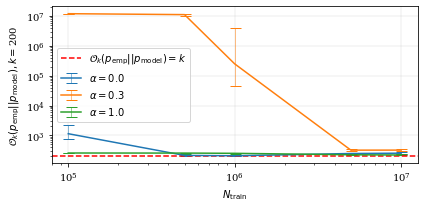

In [9]:
# Fig. 4

gt_confs = {
        r'$\alpha = 0.0$': {
            "gt_interpolation": 0.0,
            "gt_interpolation_mode": 'p',
        },
        r'$\alpha = 0.3$': {
            "gt_interpolation": 0.3,
            "gt_interpolation_mode": 'logp',
        },
        r'$\alpha = 1.0$': {
            "gt_interpolation": 1.0,
            "gt_interpolation_mode": 'p',
        },
    }

cost_ks = [200]
fig, ax = plt.subplots(1,1, figsize=(6,3))

cost_from = 'emp'

for axi, cost_k in enumerate(cost_ks):
    metric_name = f'cost_{cost_from}_model'
    training_set_sizes = df['training_set_size'].sort_values().unique()
    k_list = df['k_list'][0]
    k_mapped = k_list.index(cost_k)


    for i_offset, (gt_label, gt_config) in enumerate(gt_confs.items()):
        cost_fixed_k = []
        for ts in training_set_sizes:
            cost_all_k = numpy.array(df.loc[(df['gt_interpolation'] == gt_config['gt_interpolation']) & (df['gt_interpolation_mode'] == gt_config['gt_interpolation_mode']) & (df['true_hs'] > 0) & (df['training_set_size'] == ts) & (df['model_hs'] == 512)][metric_name].to_list())
            cost_fixed_k.append(cost_all_k[:, k_mapped, None])
        cost_fixed_k = numpy.concatenate(cost_fixed_k, axis=1)
        median_cost = numpy.quantile(cost_fixed_k, axis=0, q=0.5)
        lower_quantile = numpy.quantile(cost_fixed_k, axis=0, q=0.25)
        upper_quntile = numpy.quantile(cost_fixed_k, axis=0, q=0.75)

        xs = training_set_sizes
        ax.errorbar(xs, y=median_cost, yerr=[median_cost-lower_quantile, upper_quntile-median_cost], label=gt_label, elinewidth=0.5, capsize=5.5)

    ax.axhline(y=cost_k, color='red', linestyle='--', label=r'$\mathcal{O}_{k}(p_\mathrm{%s}|| p_\mathrm{model})=k$'%cost_from)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$N_\mathrm{train}}$')
    ax.set_ylabel(r'$\mathcal{O}_{k}(p_\mathrm{%s}|| p_\mathrm{model}), k=$'%cost_from+f"{cost_k}")
    ax.grid(lw=0.2)
plt.tight_layout()
plt.show()

In [10]:
# 6 structurally different datasets

dataset_confs = {
    r'$N_\mathrm{train}=5 \times 10^5, \alpha=0.0$': {
        'training_set_size': 5*int(1e5),
        'gt_interpolation': 0.0,
    },
    r'$N_\mathrm{train}=5 \times 10^6, \alpha=0.0$': {
        'training_set_size': 5*int(1e6),
        'gt_interpolation': 0.0,
    },
    r'$N_\mathrm{train}=5 \times 10^5, \alpha=0.3$': {
        'training_set_size': 5*int(1e5),
        'gt_interpolation': 0.3,
    },
    r'$N_\mathrm{train}=5 \times 10^6, \alpha=0.3$': {
        'training_set_size': 5*int(1e6),
        'gt_interpolation': 0.3,
    },
    r'$N_\mathrm{train}=5 \times 10^5, \alpha=1.0$': {
        'training_set_size': 5*int(1e5),
        'gt_interpolation': 1.0,
    },
    r'$N_\mathrm{train}=5 \times 10^6, \alpha=1.0$': {
        'training_set_size': 5*int(1e6),
        'gt_interpolation': 1.0,
    },
}

colors = {
    0.0: 'blue',
    0.3: 'green',
    1.0: 'purple',
}

lstyles = {
    5*int(1e5): '-',
    5*int(1e6): '--',
}

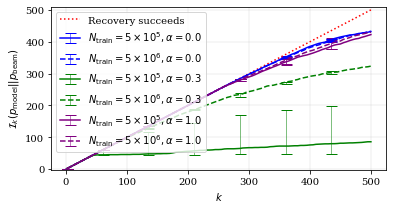

In [11]:
# Fig. 5 left

dec_width = 500
model_size = 512
algo = 'beam'
p_distr = 'model'

k_list = df['k_list'][0]
fig, ax = plt.subplots(1,1, figsize=(6,3))

for data_descr, data_conf in dataset_confs.items():
    subdf = df.loc[(df['training_set_size'] == data_conf['training_set_size']) & (df['gt_interpolation'] == data_conf['gt_interpolation']) & (df['model_hs'] == model_size)]
    if algo == 'beam':
        intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}']
    elif algo == 'anc':
        intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}_t_10']
    
    numpy_intersection = numpy.array(intersection.to_list())
    median_intersection = numpy.quantile(numpy_intersection, axis=0, q=0.5)
    lower_quantile = numpy.quantile(numpy_intersection, axis=0, q=0.25)
    upper_quntile = numpy.quantile(numpy_intersection, axis=0, q=0.75)
    
    ax.errorbar(k_list, y=median_intersection, yerr=[median_intersection-lower_quantile, upper_quntile-median_intersection], label=data_descr, errorevery=15, elinewidth=0.5, capsize=5.5, color=colors[data_conf['gt_interpolation']], ls=lstyles[data_conf['training_set_size']])
    
ax.plot(k_list, k_list, ls='dotted', label='Recovery succeeds', color='red')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\mathcal{I}_k(p_\mathrm{%s}||p_\mathrm{%s})$' % (p_distr,algo))
ax.set_ylim(-2, dec_width+10)
ax.grid(lw=0.2)
ax.legend(loc='upper left')

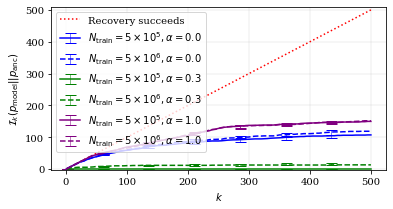

In [12]:
# Fig. 5 right

dec_width = 500
model_size = 512
algo = 'anc'
p_distr = 'model'

k_list = df['k_list'][0]
fig, ax = plt.subplots(1,1, figsize=(6,3))

for data_descr, data_conf in dataset_confs.items():
    subdf = df.loc[(df['training_set_size'] == data_conf['training_set_size']) & (df['gt_interpolation'] == data_conf['gt_interpolation']) & (df['model_hs'] == model_size)]
    if algo == 'beam':
        intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}']
    elif algo == 'anc':
        intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}_t_10']
    
    numpy_intersection = numpy.array(intersection.to_list())
    median_intersection = numpy.quantile(numpy_intersection, axis=0, q=0.5)
    lower_quantile = numpy.quantile(numpy_intersection, axis=0, q=0.25)
    upper_quntile = numpy.quantile(numpy_intersection, axis=0, q=0.75)
    
    ax.errorbar(k_list, y=median_intersection, yerr=[median_intersection-lower_quantile, upper_quntile-median_intersection], label=data_descr, errorevery=15, elinewidth=0.5, capsize=5.5, color=colors[data_conf['gt_interpolation']], ls=lstyles[data_conf['training_set_size']])
    
ax.plot(k_list, k_list, ls='dotted', label='Recovery succeeds', color='red')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\mathcal{I}_k(p_\mathrm{%s}||p_\mathrm{%s})$' % (p_distr,algo))
ax.set_ylim(-2, dec_width+10)
ax.grid(lw=0.2)
ax.legend(loc='upper left')

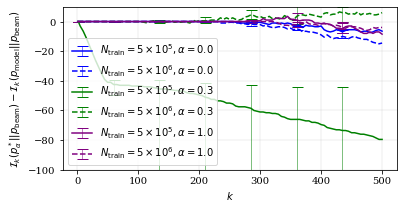

In [13]:
# Fig. 6 left

dec_width = 500
model_size = 512
algo = 'beam'

k_list = df['k_list'][0]
fig, ax = plt.subplots(1,1, figsize=(6,3))

for data_descr, data_conf in dataset_confs.items():
    pdistr_intersections = []
    for p_distr in ['true', 'model']:
        
        subdf = df.loc[(df['training_set_size'] == data_conf['training_set_size']) & (df['gt_interpolation'] == data_conf['gt_interpolation']) & (df['model_hs'] == model_size)]
        if algo == 'beam':
            intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}']
        elif algo == 'anc':
            intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}_t_10']

        numpy_intersection = numpy.array(intersection.to_list())
        pdistr_intersections.append(numpy_intersection)
        
    intersection_reduction = pdistr_intersections[0] - pdistr_intersections[1]
    median_intersection = numpy.quantile(intersection_reduction, axis=0, q=0.5)
    lower_quantile = numpy.quantile(intersection_reduction, axis=0, q=0.25)
    upper_quntile = numpy.quantile(intersection_reduction, axis=0, q=0.75)

    ax.errorbar(k_list, y=median_intersection, yerr=[median_intersection-lower_quantile, upper_quntile-median_intersection], label=data_descr, errorevery=15, elinewidth=0.5, capsize=5.5, color=colors[data_conf['gt_interpolation']], ls=lstyles[data_conf['training_set_size']])
    
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\mathcal{I}_k(p^*_{\alpha}||p_\mathrm{%s}) - \mathcal{I}_k(p_\mathrm{model}||p_\mathrm{%s})$' % (algo,algo))
ax.set_ylim(-100,10)
ax.grid(lw=0.2)
ax.legend(loc='lower left')

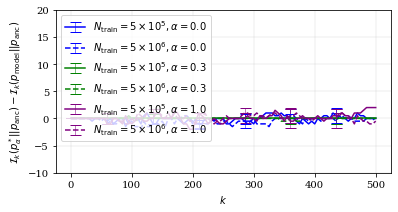

In [14]:
# Fig. 6 right

dec_width = 500
model_size = 512
algo = 'anc'

k_list = df['k_list'][0]
fig, ax = plt.subplots(1,1, figsize=(6,3))

for data_descr, data_conf in dataset_confs.items():
    pdistr_intersections = []
    for p_distr in ['true', 'model']:
        
        subdf = df.loc[(df['training_set_size'] == data_conf['training_set_size']) & (df['gt_interpolation'] == data_conf['gt_interpolation']) & (df['model_hs'] == model_size)]
        if algo == 'beam':
            intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}']
        elif algo == 'anc':
            intersection = subdf[f'intersection_{p_distr}_{algo}{dec_width}_t_10']

        numpy_intersection = numpy.array(intersection.to_list())
        pdistr_intersections.append(numpy_intersection)
        
    intersection_reduction = pdistr_intersections[0] - pdistr_intersections[1]
    median_intersection = numpy.quantile(intersection_reduction, axis=0, q=0.5)
    lower_quantile = numpy.quantile(intersection_reduction, axis=0, q=0.25)
    upper_quntile = numpy.quantile(intersection_reduction, axis=0, q=0.75)
    
    ax.errorbar(k_list, y=median_intersection, yerr=[median_intersection-lower_quantile, upper_quntile-median_intersection], label=data_descr, errorevery=15, elinewidth=0.5, capsize=5.5, color=colors[data_conf['gt_interpolation']], ls=lstyles[data_conf['training_set_size']])
    
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\mathcal{I}_k(p^*_{\alpha}||p_\mathrm{%s}) - \mathcal{I}_k(p_\mathrm{model}||p_\mathrm{%s})$' % (algo,algo))
ax.set_ylim(-10, 20)
ax.grid(lw=0.2)
ax.legend(loc='upper left')